In [2]:
import pandas as pd
import numpy as np
import random

# File operations
from copy import deepcopy
import glob
import os
from pathlib import Path

# Stats
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu
import statsmodels.stats.multitest

# neuromaps
from enigmatoolbox.datasets import load_sc, load_fc

# Set seed to 127
random.seed(127)

%load_ext rpy2.ipython

In [3]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(glue)
    library(ggseg)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

# Are there sex-based differences in regional homotopic FC?

In [5]:
subject_metadata = pd.read_csv("/Users/abry4213/data/HCP100/sample_metadata/HCP100_subject_info.csv").rename(columns={"Sample_ID": "Subject"})

data_path = "/Users/abry4213/data/HCP100/"

# Load in all the pyspi homotopic res
pearson_all_res = pd.concat([pd.read_csv(f) for f in glob.glob(data_path + "time_series_features/pyspi/*_all_pyspi_Pearson_results.csv")])
pearson_homotopic_res = (pearson_all_res
                         .query("SPI=='cov_EmpiricalCovariance' & base_region_from == base_region_to")
                         .rename(columns={"Subject_ID": "Subject"})
                         )

pearson_homotopic_res_with_demo = (pearson_homotopic_res.merge(subject_metadata, on="Subject")
                                   .groupby(['base_region_to', 'Subject', 'Gender'])['value']
                                    .mean()
                                    .reset_index()
)
# Fit a Wilcox rank-sum test to compare to value between M and F for each base_region_to
pearson_homotopic_sex_diffs_wilcox_res = (pearson_homotopic_res_with_demo
              .groupby("base_region_to")
              .apply(lambda x: mannwhitneyu(x.query("Gender=='M'")['value'], x.query("Gender=='F'")['value']))
              .reset_index()
              # Separate '0' into statistic and p
                .assign(statistic = lambda x: x[0].apply(lambda y: y.statistic),
                        p = lambda x: x[0].apply(lambda y: y.pvalue))
                .drop(columns=0)
                .assign(p_adj = lambda x: statsmodels.stats.multitest.multipletests(x['p'], method='fdr_bh')[1])
              )

pearson_homotopic_sex_diffs_wilcox_res.query("p_adj < 0.05")

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_57169/1402746863.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pearson_homotopic_sex_diffs_wilcox_res = (pearson_homotopic_res_with_demo


,base_region_to,statistic,p,p_adj
23,posteriorcingulate,747.0,0.000626,0.021295


Joining with `by = join_by(base_region_to)`


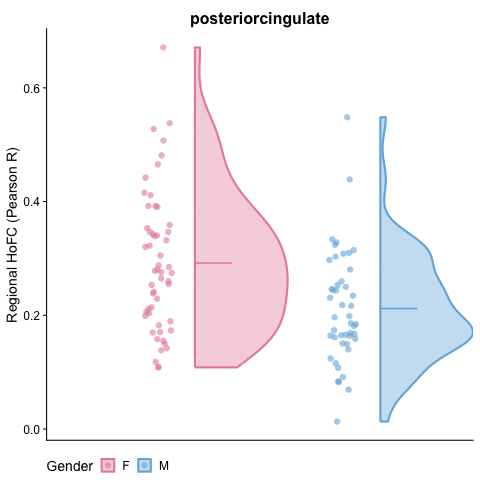

In [6]:
%%R -i pearson_homotopic_res_with_demo,pearson_homotopic_sex_diffs_wilcox_res

pearson_homotopic_res_with_demo %>% 
    left_join(., pearson_homotopic_sex_diffs_wilcox_res) %>%
    filter(p_adj < 0.05) %>%
    ggplot(data=., mapping=aes(x=Gender, y=value, fill=Gender, color=Gender)) +
    facet_wrap(base_region_to ~ ., scales="free") +
    geom_violinhalf(scale="width", position = position_nudge(x=0.2), width=1, alpha=0.4, linewidth=1)  +
    geom_point(aes(color = Gender), position = position_jitter(width = 0.075, height=0),
                            size = 3, alpha=0.6, stroke=0) +
    stat_summary(fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
            show.legend=FALSE, position = position_nudge(x=0.3))+
    ylab("Regional HoFC (Pearson R)") +
    scale_fill_manual(values=c("M"="#73B3DF", "F"="#E68EA8")) +
    scale_color_manual(values=c("M"="#73B3DF", "F"="#E68EA8")) +
    theme(axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(),
          axis.title.x = element_blank(),
          legend.position="bottom",
          strip.text = element_text(face='bold', size=16),
          strip.background = element_blank()) 
# ggsave("../plots/sex_differences/posterior_cingulate_Pearson_HoFC_diffs.svg", width=5, height=4, units='in', dpi=300)


## Are there brain-wide sex differences?

In [8]:
sex_diffs_HoFC_whole_brain = (pearson_homotopic_res_with_demo
 .groupby(['base_region_to', 'Gender'])['value']
 .mean()
 .reset_index()
 .groupby('base_region_to')
 # Find the difference in value in Gender=='F' minus Gender=='M'
    .apply(lambda x: x['value'].iloc[0] - x['value'].iloc[1])
    .reset_index()
    .rename(columns={0: 'F_minus_M_HoFC',
                     'base_region_to': 'Base_Region'})
)

sex_diffs_HoFC_whole_brain.head()

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_57169/1949672439.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sex_diffs_HoFC_whole_brain = (pearson_homotopic_res_with_demo


,Base_Region,F_minus_M_HoFC
0,bankssts,0.024396
1,caudalanteriorcingulate,0.037872
2,caudalmiddlefrontal,0.022998
3,cuneus,0.033571
4,entorhinal,0.005377


Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


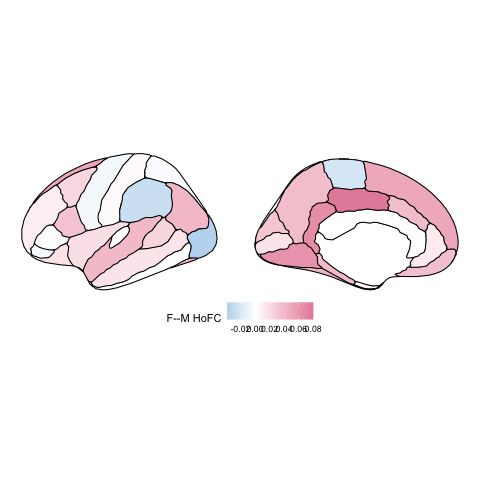

In [9]:
%%R -i sex_diffs_HoFC_whole_brain

### Pearson FC in brain ###
sex_diffs_HoFC_whole_brain %>%
  ungroup() %>%
  mutate(label = glue("lh_{Base_Region}")) %>%
  left_join(., as_tibble(dk)) %>%
  ggseg(atlas = dk, mapping = aes(fill = F_minus_M_HoFC),
        position = "stacked", colour = "black", hemisphere="left",
        linewidth=0.5) +
  theme_void() +
  labs(fill = "F--M HoFC") +
  theme(plot.title = element_blank(),
        legend.position = "bottom") +
  scale_fill_gradient2(low="#73B3DF", mid="white", high="#E68EA8",
                       midpoint=0, na.value="white") 
# ggsave("../plots/sex_differences/F_vs_M_HoFC_mean_brain.svg", width = 4, height = 3)